In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "../../" not in sys.path:
    sys.path.append("../../")
    print("[sys.path]:", sys.path)

[sys.path]: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages', '../../']


In [3]:
from src.data.babel import BabelDataset

/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# NOTE: parameters
pipeline_name = None

In [5]:
# Parameters
pipeline_name = "babel"


In [6]:
from src.data.pipelines._registery import PIPELINE_REGISTRY

pipeline_names = [name for names in PIPELINE_REGISTRY.values() for name in names]

if pipeline_name not in pipeline_names:
    raise ValueError(f"Pipeline '{pipeline_name}' is not registered. Available pipelines: {pipeline_names}")
else:
    print(f"[validation]: pipeline '{pipeline_name}' is registered and available.")

[validation]: pipeline 'babel' is registered and available.


In [7]:
train_dataset = BabelDataset(
    split="train",
    pipeline=pipeline_name
)
validation_dataset = BabelDataset(
    split="validation",
    pipeline=pipeline_name
)

Repo card metadata block was not found. Setting CardData to empty.


Repo card metadata block was not found. Setting CardData to empty.


In [8]:
print("[#train_dataset]:", len(train_dataset))
print("[#validation_dataset]:", len(validation_dataset))

[#train_dataset]: 6615
[#validation_dataset]: 2193


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [10]:
plt.style.use('default')
sns.set_palette("husl")

In [11]:
def analyze_prompts(dataset, dataset_name="Dataset"):
    all_prompts = []
    sample_prompt_counts = []
    source_counts = Counter()
    is_sequence_counts = Counter()
    durations = []
    sequence_durations = []
    frame_durations = []
    spans_per_prompt = defaultdict(list)
    
    motion_lengths_frames = []
    motion_lengths_seconds = []
    spans_per_motion = []
    spans_durations_per_motion = []
    
    for i, sample in enumerate(dataset):
        prompts_list = sample.get("prompts", [])
        sample_prompt_counts.append(len(prompts_list))
        
        motion = sample.get("motion", {})
        if isinstance(motion, dict) and "new_joint_vecs" in motion:
            motion_length = len(motion["new_joint_vecs"])
            motion_lengths_frames.append(motion_length)
            motion_lengths_seconds.append(motion_length / DEFAULT_FPS)
        
        motion_spans = []
        motion_spans_durations = []
        
        for prompt_data in prompts_list:
            prompt_text = prompt_data.get("text", "")
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            is_sequence = prompt_data.get("is_sequence", True)
            
            all_prompts.append(prompt_text)
            source_counts[source] += 1
            is_sequence_counts[is_sequence] += 1
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                durations.append(duration_frames)
                spans_per_prompt[prompt_text].append(span)
                motion_spans.append(span)
                motion_spans_durations.append(duration_frames)
                
                if is_sequence:
                    sequence_durations.append(duration_frames)
                else:
                    frame_durations.append(duration_frames)
        
        spans_per_motion.append(len(motion_spans))
        spans_durations_per_motion.append(sum(motion_spans_durations) if motion_spans_durations else 0)
    
    return {
        'all_prompts': all_prompts,
        'sample_prompt_counts': sample_prompt_counts,
        'source_counts': source_counts,
        'is_sequence_counts': is_sequence_counts,
        'durations': durations,
        'sequence_durations': sequence_durations,
        'frame_durations': frame_durations,
        'spans_per_prompt': spans_per_prompt,
        'dataset_name': dataset_name,
        'motion_lengths_frames': motion_lengths_frames,
        'motion_lengths_seconds': motion_lengths_seconds,
        'spans_per_motion': spans_per_motion,
        'spans_durations_per_motion': spans_durations_per_motion
    }

In [12]:
train_analysis = analyze_prompts(train_dataset, "Train")
validation_analysis = analyze_prompts(validation_dataset, "Validation")

In [13]:
print("=== BASIC STATISTICS ===")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(validation_dataset)} samples")
print()

for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
Train Dataset: 6615 samples
Validation Dataset: 2193 samples

Train Dataset:
  Total prompts: 143365
  Unique prompts: 9422
  Avg prompts per sample: 21.67
  Min prompts per sample: 3
  Max prompts per sample: 330

  Source distribution:
    proc_label: 43137 (30.1%)
    raw_label: 43137 (30.1%)
    act_cat: 57091 (39.8%)

  Sequence vs Frame annotations:
    Sequence: 22720 (15.8%)
    Frame: 120645 (84.2%)

  Duration statistics (frames):
    Min: -51 frames (-2.55s)
    Mean: 72.96 frames (3.65s)
    Max: 5271 frames (263.55s)
    Std: 164.16 frames (8.21s)
--------------------------------------------------
Validation Dataset:
  Total prompts: 52433
  Unique prompts: 4336
  Avg prompts per sample: 23.91
  Min prompts per sample: 3
  Max prompts per sample: 331

  Source distribution:
    proc_label: 15744 (30.0%)
    raw_label: 15744 (30.0%)
    act_cat: 20945 (39.9%)

  Sequence vs Frame annotations:
    Sequence: 7794 (14.9%)
    Frame: 44639 (85.1%)

  Du

<div class="alert alert-info">

#### **Number of Motions**

This shows the total number of motion sequences in each dataset split.

</div>

=== NUMBER OF MOTIONS ===
Train Dataset: 6615 motions
Validation Dataset: 2193 motions


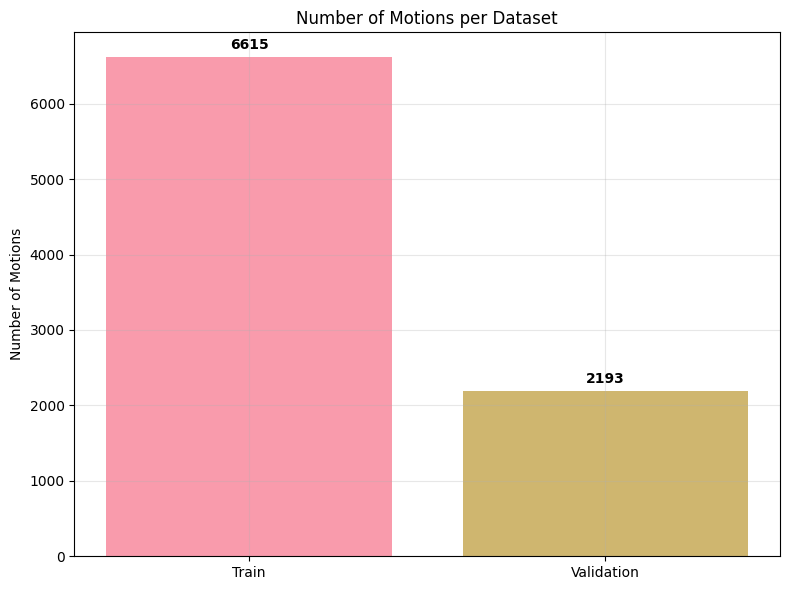

In [14]:
print("=== NUMBER OF MOTIONS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    num_motions = len(analysis['motion_lengths_frames'])
    print(f"{name} Dataset: {num_motions} motions")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
datasets = ['Train', 'Validation']
motion_counts = [len(train_analysis['motion_lengths_frames']), len(validation_analysis['motion_lengths_frames'])]
colors = ['C0', 'C1']

bars = ax.bar(datasets, motion_counts, color=colors, alpha=0.7)
ax.set_title('Number of Motions per Dataset')
ax.set_ylabel('Number of Motions')
ax.grid(True, alpha=0.3)

for bar, count in zip(bars, motion_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(motion_counts)*0.01, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Motion Length Distribution**

This shows the distribution of motion sequence lengths in both frames and seconds, with horizontal lines indicating minimum, maximum, and average values.

</div>

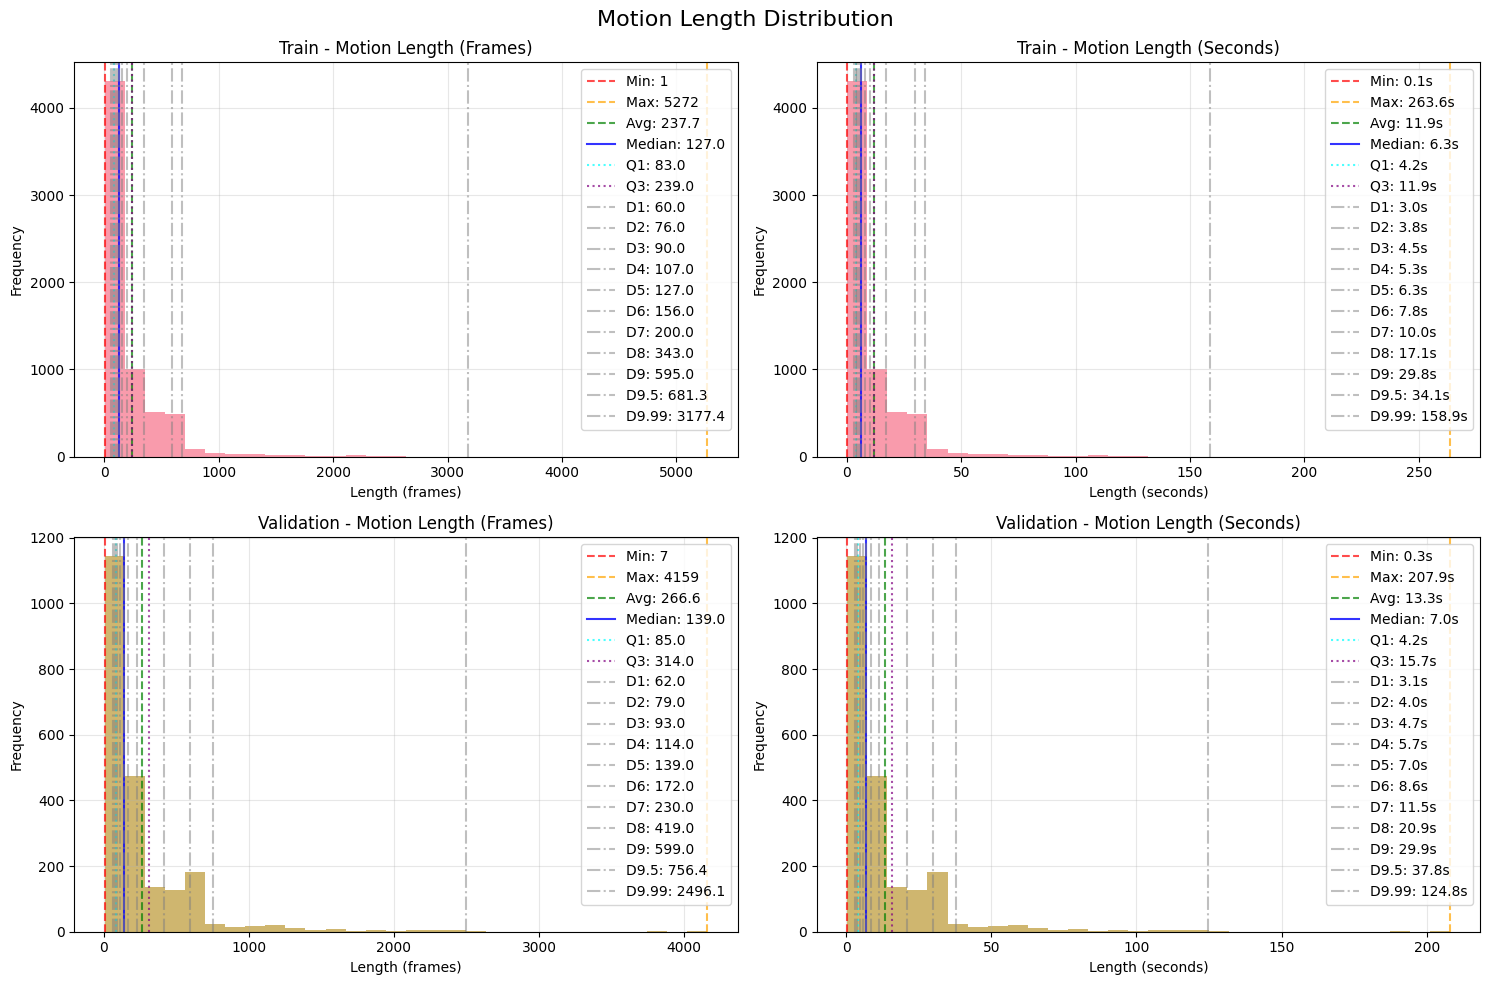

=== MOTION LENGTH STATISTICS ===

Train Dataset:
  Frames - Min: 1, Mean: 237.68, Max: 5272
  Seconds - Min: 0.05, Mean: 11.88, Max: 263.60
  75th percentile - Frames: 239.00, Seconds: 11.95
--------------------------------------------------

Validation Dataset:
  Frames - Min: 7, Mean: 266.62, Max: 4159
  Seconds - Min: 0.35, Mean: 13.33, Max: 207.95
  75th percentile - Frames: 314.00, Seconds: 15.70
--------------------------------------------------


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Motion Length Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        # NOTE: frames distribution
        axes[i, 0].hist(lengths_frames, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Motion Length (Frames)')
        axes[i, 0].set_xlabel('Length (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        min_frames = np.min(lengths_frames)
        max_frames = np.max(lengths_frames)
        avg_frames = np.mean(lengths_frames)
        median_frames = np.median(lengths_frames)
        q1_frames = np.percentile(lengths_frames, 25)
        q3_frames = np.percentile(lengths_frames, 75)
        
        axes[i, 0].axvline(min_frames, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_frames}')
        axes[i, 0].axvline(max_frames, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_frames}')
        axes[i, 0].axvline(avg_frames, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_frames:.1f}')
        axes[i, 0].axvline(median_frames, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_frames:.1f}')
        axes[i, 0].axvline(q1_frames, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_frames:.1f}')
        axes[i, 0].axvline(q3_frames, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_frames:.1f}')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(lengths_frames, d*10)
            axes[i, 0].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i, 0].legend()
        
        # NOTE: seconds distribution
        axes[i, 1].hist(lengths_seconds, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 1].set_title(f'{name} - Motion Length (Seconds)')
        axes[i, 1].set_xlabel('Length (seconds)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        min_seconds = np.min(lengths_seconds)
        max_seconds = np.max(lengths_seconds)
        avg_seconds = np.mean(lengths_seconds)
        median_seconds = np.median(lengths_seconds)
        q1_seconds = np.percentile(lengths_seconds, 25)
        q3_seconds = np.percentile(lengths_seconds, 75)
        
        axes[i, 1].axvline(min_seconds, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_seconds:.1f}s')
        axes[i, 1].axvline(max_seconds, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_seconds:.1f}s')
        axes[i, 1].axvline(avg_seconds, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_seconds:.1f}s')
        axes[i, 1].axvline(median_seconds, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_seconds:.1f}s')
        axes[i, 1].axvline(q1_seconds, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_seconds:.1f}s')
        axes[i, 1].axvline(q3_seconds, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_seconds:.1f}s')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(lengths_seconds, d*10)
            axes[i, 1].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}s')
        axes[i, 1].legend()

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        print(f"\n{name} Dataset:")
        print(f"  Frames - Min: {np.min(lengths_frames)}, Mean: {np.mean(lengths_frames):.2f}, Max: {np.max(lengths_frames)}")
        print(f"  Seconds - Min: {np.min(lengths_seconds):.2f}, Mean: {np.mean(lengths_seconds):.2f}, Max: {np.max(lengths_seconds):.2f}")
        print(f"  75th percentile - Frames: {np.percentile(lengths_frames, 75):.2f}, Seconds: {np.percentile(lengths_seconds, 75):.2f}")
    print("-" * 50)

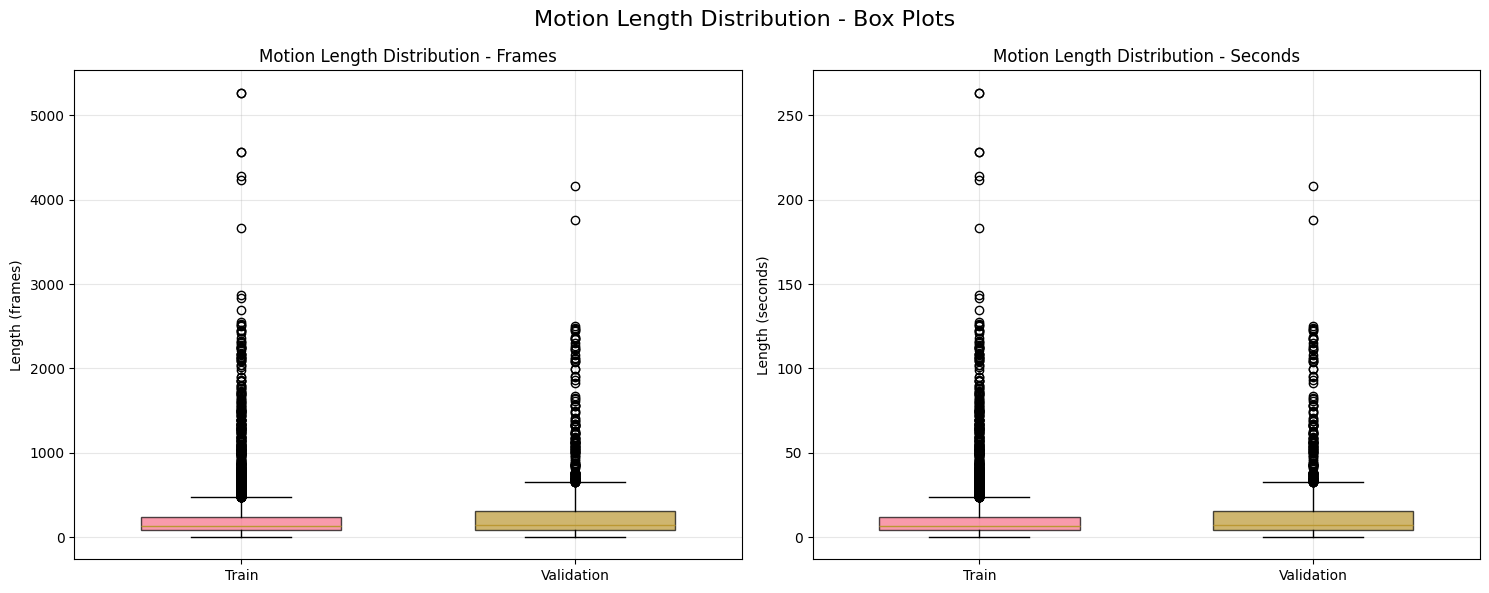

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Motion Length Distribution - Box Plots', fontsize=16)

datasets = ['Train', 'Validation']
for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        box_data_frames = [lengths_frames]
        bp1 = axes[0].boxplot(box_data_frames, positions=[i+1], widths=0.6, patch_artist=True)
        bp1['boxes'][0].set_facecolor(f'C{i}')
        bp1['boxes'][0].set_alpha(0.7)
        
        box_data_seconds = [lengths_seconds]
        bp2 = axes[1].boxplot(box_data_seconds, positions=[i+1], widths=0.6, patch_artist=True)
        bp2['boxes'][0].set_facecolor(f'C{i}')
        bp2['boxes'][0].set_alpha(0.7)

axes[0].set_title('Motion Length Distribution - Frames')
axes[0].set_ylabel('Length (frames)')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(datasets)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Motion Length Distribution - Seconds')
axes[1].set_ylabel('Length (seconds)')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(datasets)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Prompts per Motion Distribution**

This shows how many prompts are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

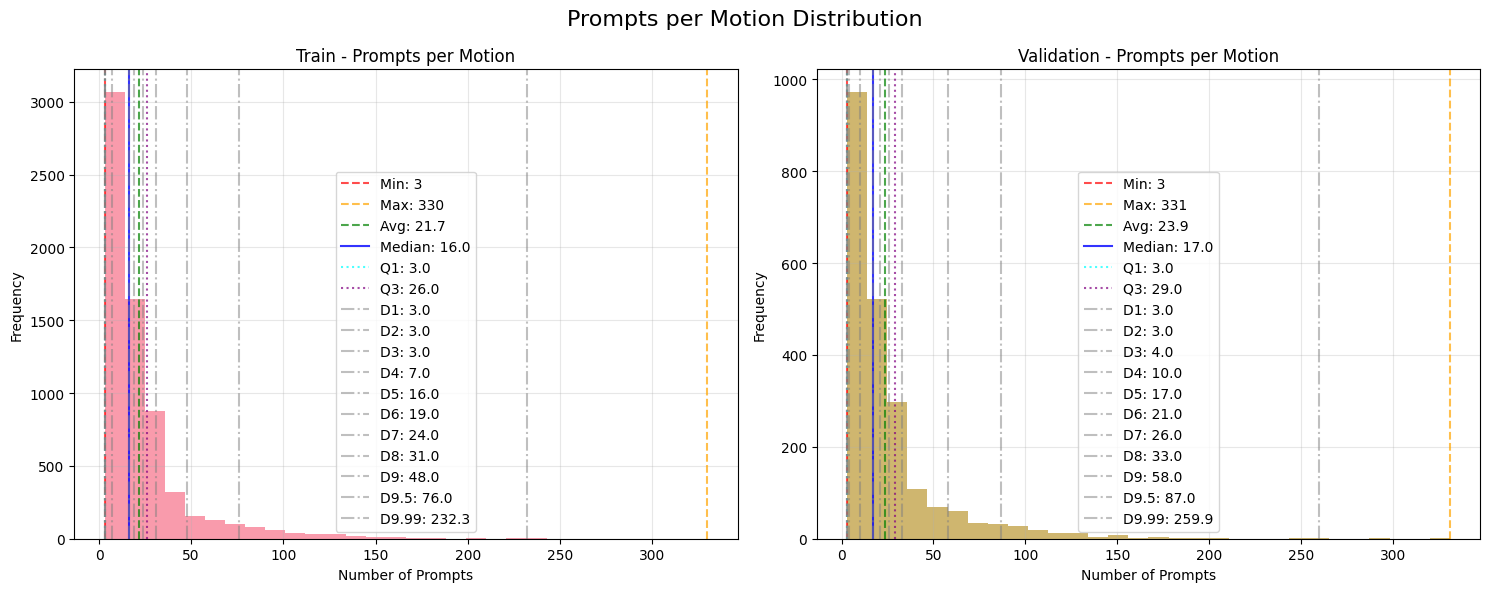

=== PROMPTS PER MOTION STATISTICS ===

Train Dataset:
  Min: 3, Mean: 21.67, Max: 330
  75th percentile: 26.00
--------------------------------------------------

Validation Dataset:
  Min: 3, Mean: 23.91, Max: 331
  75th percentile: 29.00
--------------------------------------------------


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        axes[i].hist(prompts_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Prompts per Motion')
        axes[i].set_xlabel('Number of Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_prompts = np.min(prompts_per_motion)
        max_prompts = np.max(prompts_per_motion)
        avg_prompts = np.mean(prompts_per_motion)
        median_prompts = np.median(prompts_per_motion)
        q1_prompts = np.percentile(prompts_per_motion, 25)
        q3_prompts = np.percentile(prompts_per_motion, 75)
        
        axes[i].axvline(min_prompts, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_prompts}')
        axes[i].axvline(max_prompts, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_prompts}')
        axes[i].axvline(avg_prompts, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_prompts:.1f}')
        axes[i].axvline(median_prompts, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_prompts:.1f}')
        axes[i].axvline(q1_prompts, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_prompts:.1f}')
        axes[i].axvline(q3_prompts, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_prompts:.1f}')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(prompts_per_motion, d*10)
            axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(prompts_per_motion)}, Mean: {np.mean(prompts_per_motion):.2f}, Max: {np.max(prompts_per_motion)}")
        print(f"  75th percentile: {np.percentile(prompts_per_motion, 75):.2f}")
    print("-" * 50)

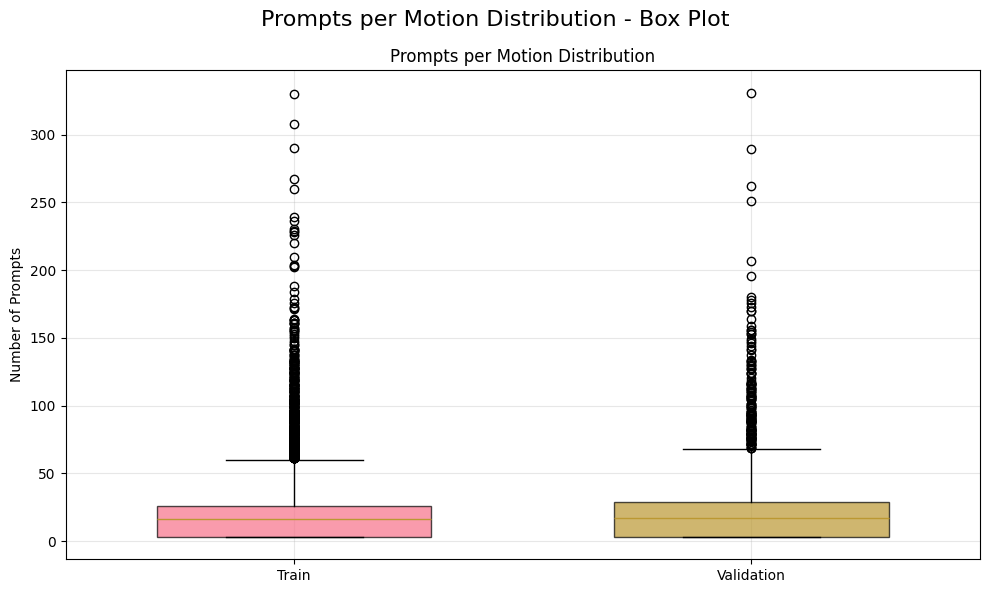

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Prompts per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    prompts_per_motion = analysis['sample_prompt_counts']
    if prompts_per_motion:
        box_data.append(prompts_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Prompts per Motion Distribution')
ax.set_ylabel('Number of Prompts')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Spans per Motion Distribution**

This shows how many spans (temporal segments) are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

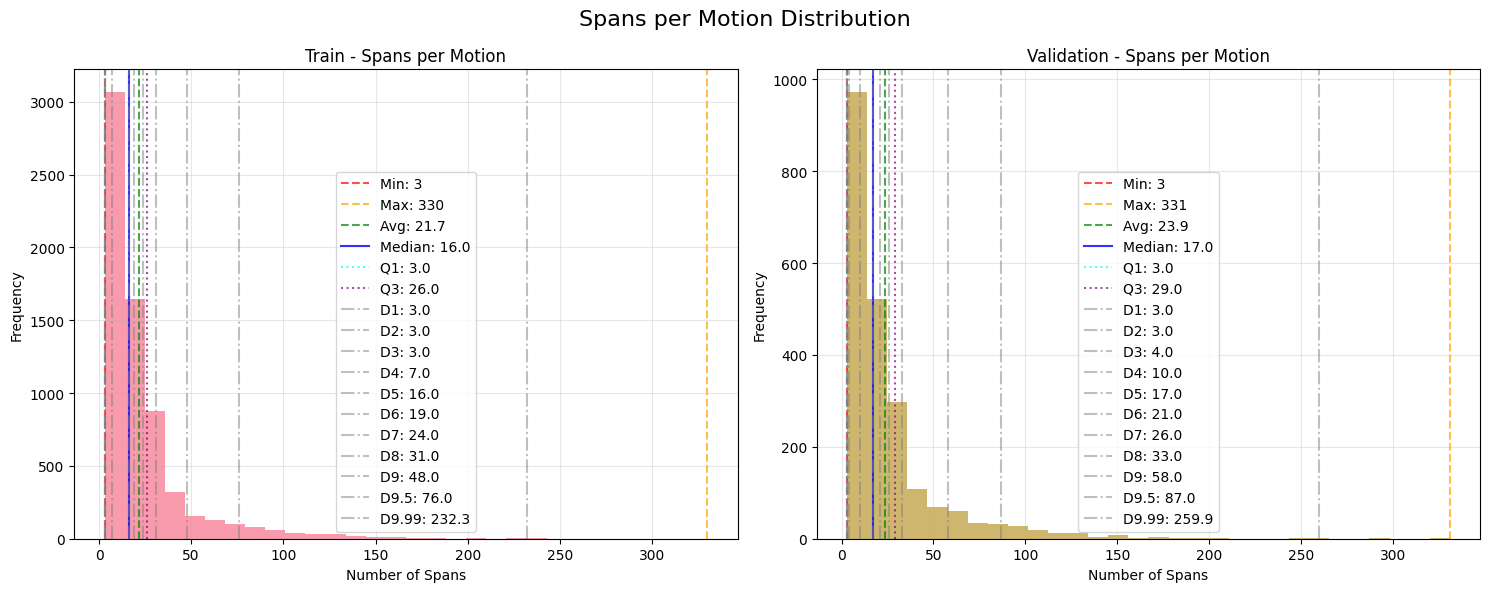

=== SPANS PER MOTION STATISTICS ===

Train Dataset:
  Min: 3, Mean: 21.67, Max: 330
  75th percentile: 26.00
--------------------------------------------------

Validation Dataset:
  Min: 3, Mean: 23.91, Max: 331
  75th percentile: 29.00
--------------------------------------------------


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        axes[i].hist(spans_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Spans per Motion')
        axes[i].set_xlabel('Number of Spans')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_spans = np.min(spans_per_motion)
        max_spans = np.max(spans_per_motion)
        avg_spans = np.mean(spans_per_motion)
        median_spans = np.median(spans_per_motion)
        q1_spans = np.percentile(spans_per_motion, 25)
        q3_spans = np.percentile(spans_per_motion, 75)
        
        axes[i].axvline(min_spans, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_spans}')
        axes[i].axvline(max_spans, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_spans}')
        axes[i].axvline(avg_spans, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_spans:.1f}')
        axes[i].axvline(median_spans, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_spans:.1f}')
        axes[i].axvline(q1_spans, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_spans:.1f}')
        axes[i].axvline(q3_spans, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_spans:.1f}')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(spans_per_motion, d*10)
            axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_per_motion)}, Mean: {np.mean(spans_per_motion):.2f}, Max: {np.max(spans_per_motion)}")
        print(f"  75th percentile: {np.percentile(spans_per_motion, 75):.2f}")
    print("-" * 50)

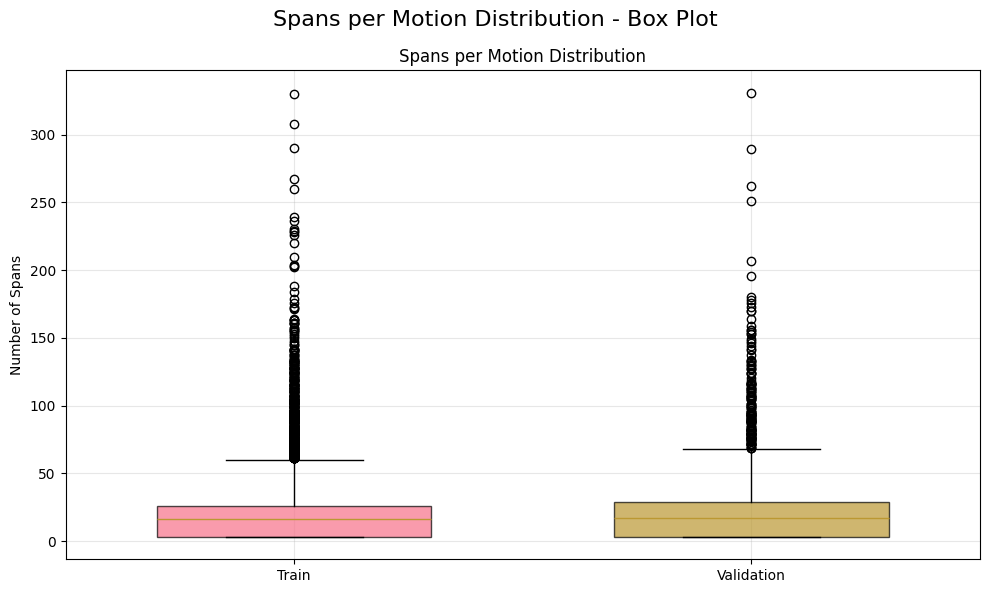

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_per_motion = analysis['spans_per_motion']
    if spans_per_motion:
        box_data.append(spans_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans per Motion Distribution')
ax.set_ylabel('Number of Spans')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Spans Duration Distribution**

This shows the distribution of individual span durations in frames, with horizontal lines indicating minimum, maximum, and average values.

</div>

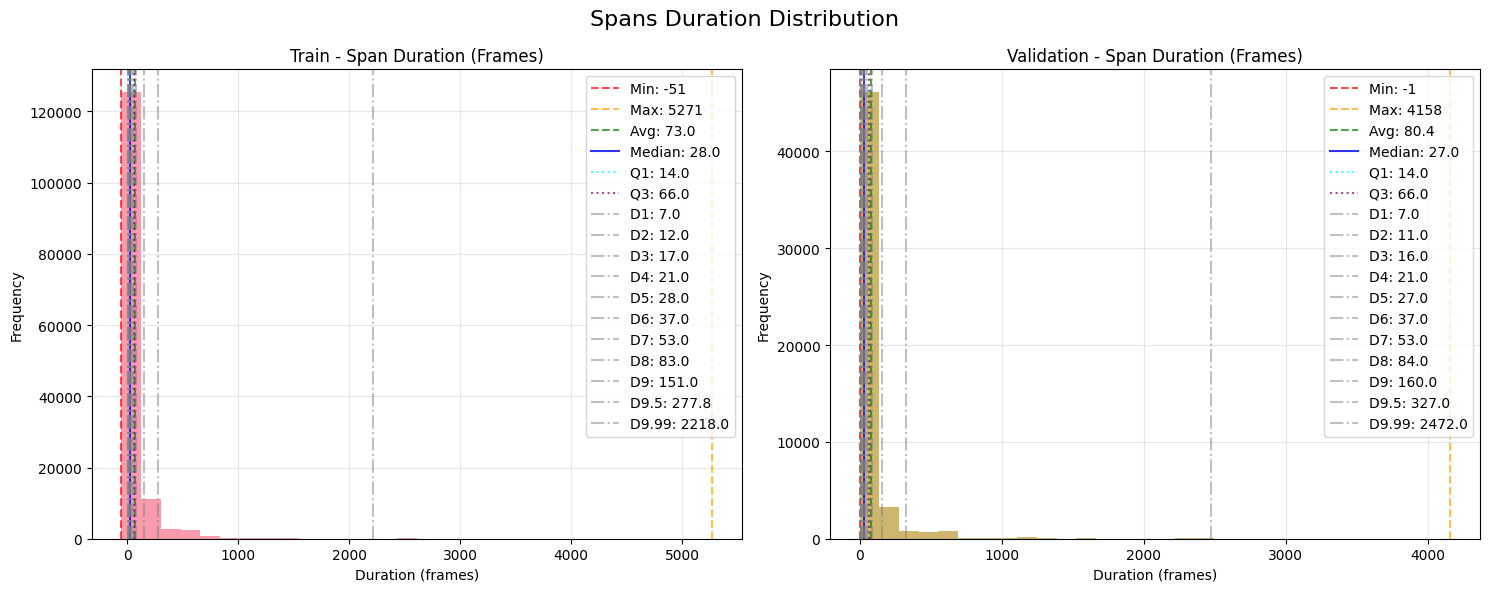

=== SPANS DURATION STATISTICS ===

Train Dataset:
  Min: -51 frames (-2.55s)
  Mean: 72.96 frames (3.65s)
  Max: 5271 frames (263.55s)
  75th percentile: 66.00 frames (3.30s)
--------------------------------------------------

Validation Dataset:
  Min: -1 frames (-0.05s)
  Mean: 80.35 frames (4.02s)
  Max: 4158 frames (207.90s)
  75th percentile: 66.00 frames (3.30s)
--------------------------------------------------


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans Duration Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        axes[i].hist(span_durations, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Span Duration (Frames)')
        axes[i].set_xlabel('Duration (frames)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(span_durations)
        max_duration = np.max(span_durations)
        avg_duration = np.mean(span_durations)
        median_duration = np.median(span_durations)
        q1_duration = np.percentile(span_durations, 25)
        q3_duration = np.percentile(span_durations, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(span_durations, d*10)
            axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS DURATION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(span_durations)} frames ({np.min(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(span_durations):.2f} frames ({np.mean(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(span_durations)} frames ({np.max(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(span_durations, 75):.2f} frames ({np.percentile(span_durations, 75)/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

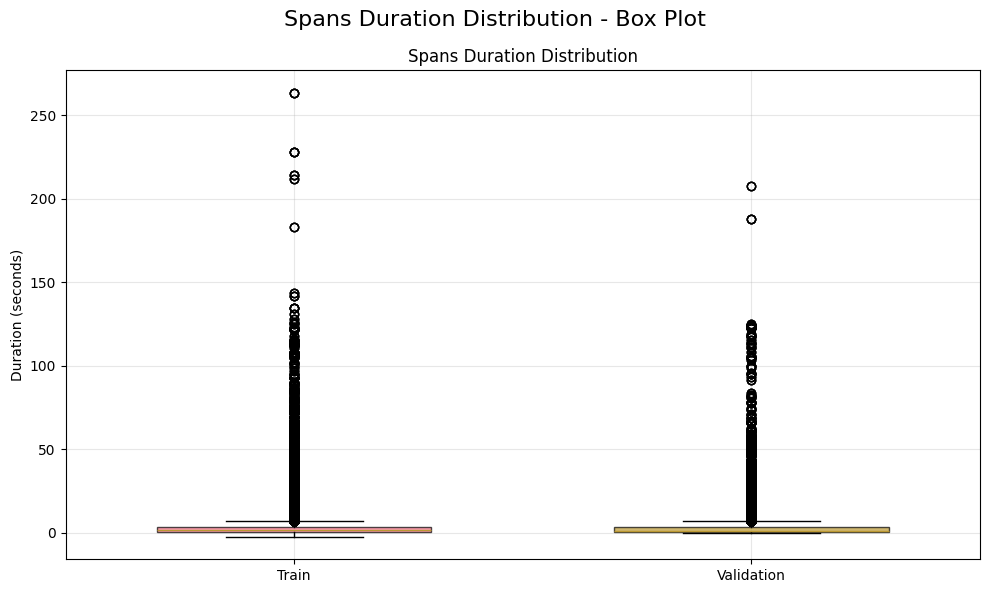

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans Duration Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    span_durations = analysis['durations']
    if span_durations:
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        box_data.append(span_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans Duration Distribution')
ax.set_ylabel('Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Total Spans per Motion (Per Motion Analysis)**

This shows the total span duration per motion sequence, indicating how much of each motion is covered by annotated spans.

</div>

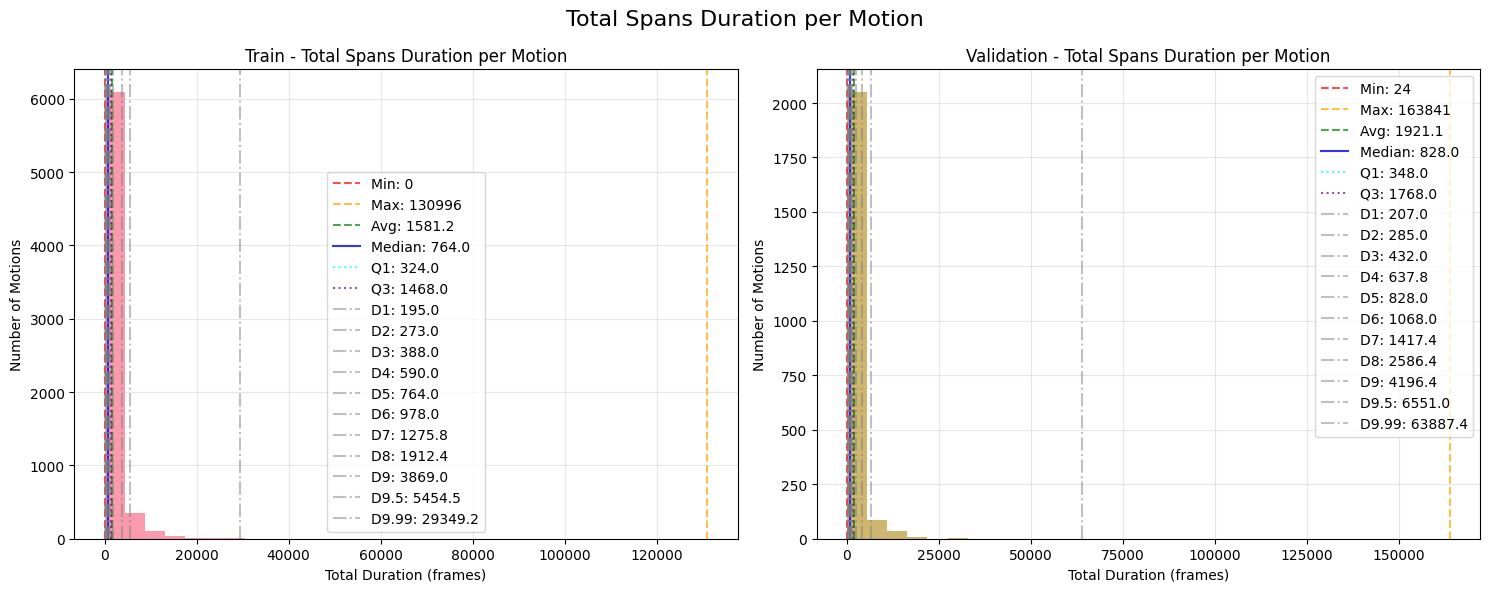

=== TOTAL SPANS DURATION PER MOTION STATISTICS ===

Train Dataset:
  Min: 0 frames (0.00s)
  Mean: 1581.18 frames (79.06s)
  Max: 130996 frames (6549.80s)
  75th percentile: 1468.00 frames (73.40s)
--------------------------------------------------

Validation Dataset:
  Min: 24 frames (1.20s)
  Mean: 1921.12 frames (96.06s)
  Max: 163841 frames (8192.05s)
  75th percentile: 1768.00 frames (88.40s)
--------------------------------------------------


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Total Spans Duration per Motion', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        axes[i].hist(spans_durations_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Total Spans Duration per Motion')
        axes[i].set_xlabel('Total Duration (frames)')
        axes[i].set_ylabel('Number of Motions')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(spans_durations_per_motion)
        max_duration = np.max(spans_durations_per_motion)
        avg_duration = np.mean(spans_durations_per_motion)
        median_duration = np.median(spans_durations_per_motion)
        q1_duration = np.percentile(spans_durations_per_motion, 25)
        q3_duration = np.percentile(spans_durations_per_motion, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        
        for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 9.5, 9.99]:
            decile = np.percentile(spans_durations_per_motion, d*10)
            axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_durations_per_motion)} frames ({np.min(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(spans_durations_per_motion):.2f} frames ({np.mean(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(spans_durations_per_motion)} frames ({np.max(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(spans_durations_per_motion, 75):.2f} frames ({np.percentile(spans_durations_per_motion, 75)/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

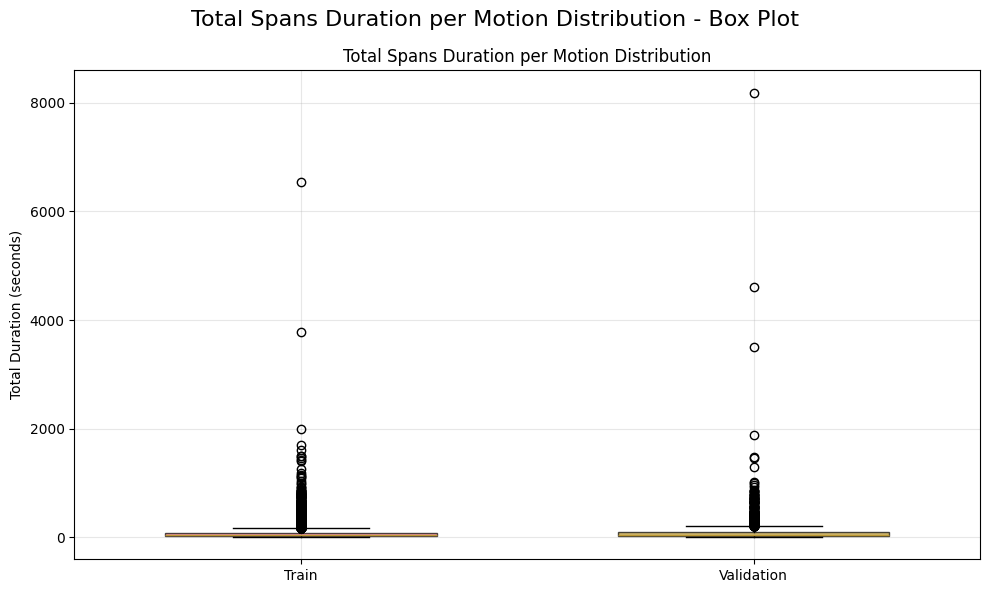

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Total Spans Duration per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    if spans_durations_per_motion:
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        box_data.append(spans_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Total Spans Duration per Motion Distribution')
ax.set_ylabel('Total Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()